# Hybrid Imaging of a Black Hole

## 환경 설정 

In [ ]:
# using PyCall

In [ ]:
# PyCall.python

In [ ]:
# ENV["PYTHON"] = "/home/bread/anaconda3/envs/astroenv/bin/python"

In [ ]:
# using Pkg
# Pkg.build("PyCall")

In [ ]:
# 변경된 경로 확인

# PyCall.python

In [1]:
using Pkg
Pkg.activate("/home/bread/astro/Comrade.jl/examples/HybridImaging")
Pkg.instantiate()

  Activating project at `~/astro/Comrade.jl/examples/HybridImaging`


## 데이터 로딩

In [2]:
using Pyehtim

In [3]:
using Comrade

In [4]:
using StableRNGs
rng = StableRNG(42)

StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055)

In [5]:
obs = ehtim.obsdata.load_uvfits("Comrade.jl/examples/Data/SR1_M87_2017_096_lo_hops_netcal_StokesI.uvfits")

Python: <ehtim.obsdata.Obsdata object at 0x7fd12bd1d5a0>

In [6]:
obs = scan_average(obs).add_fractional_noise(0.02)

┌ Info: Before homogenizing we have 25 unique times
└ @ Pyehtim /home/bread/.julia/packages/Pyehtim/YyZzM/src/Pyehtim.jl:66
┌ Info: After homogenizing we have 25 unique times
└ @ Pyehtim /home/bread/.julia/packages/Pyehtim/YyZzM/src/Pyehtim.jl:74


Python: <ehtim.obsdata.Obsdata object at 0x7fd12bd1ef20>

In [7]:
dvis  = extract_table(obs, ComplexVisibilities())

/home/bread/astro/Comrade.jl/examples/HybridImaging/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


EHTObservation{Float64,Comrade.EHTVisibilityDatum{Float64}, ...}
  source: M87
  mjd: 57849
  frequency: 2.27070703125e11
  bandwidth: 1.856e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 274


## 모델 구축(Posterior)

In [8]:
function sky(θ, metadata)
    (;c, σimg, f, r, σ, τ, ξτ, ma, mp, fg) = θ
    (;ftot, cache) = metadata
    # Form the image model
    # First transform to simplex space first applying the non-centered transform
    rast = ftot*f*(1-fg)*to_simplex(CenteredLR(), σimg.*c)
    mimg = ContinuousImage(rast, cache)
    # Form the ring model
    α = ma.*cos.(mp .- ξτ)
    β = ma.*sin.(mp .- ξτ)
    ring = smoothed(modify(MRing(α, β), Stretch(r, r*(1+τ)), Rotate(ξτ), Renormalize((ftot*(1-f)*(1-fg)))), σ)
    gauss = modify(Gaussian(), Stretch(μas2rad(250.0)), Renormalize(ftot*f*fg))
    # We group the geometric models together for improved efficiency. This will be
    # automated in future versions.
    return mimg + (ring + gauss)
end

sky (generic function with 1 method)

In [9]:
function instrument(θ, metadata)
    (; lgamp, gphase) = θ
    (; gcache, gcachep) = metadata
    # Now form our instrument model
    gvis = exp.(lgamp)
    gphase = exp.(1im.*gphase)
    jgamp = jonesStokes(gvis, gcache)
    jgphase = jonesStokes(gphase, gcachep)
    return JonesModel(jgamp*jgphase)
end

instrument (generic function with 1 method)

In [10]:
fovxy  = μas2rad(200.0)
npix   = 32
grid   = imagepixels(fovxy, fovxy, npix, npix)

RectiGrid:
	32-element LinRange{Float64, Int64}:
 -4.69663e-10,-4.39362e-10,-4.09062e-10,…,4.09062e-10,4.39362e-10,4.69663e-10
	32-element LinRange{Float64, Int64}:
 -4.69663e-10,-4.39362e-10,-4.09062e-10,…,4.09062e-10,4.39362e-10,4.69663e-10


In [11]:
cache  = create_cache(NFFTAlg(dvis), grid, BSplinePulse{3}())

VLBISkyModels.NUFTCache: 
	FT algorithm: VLBISkyModels.ObservedNUFT
	pulse: BSplinePulse{3}
	domain: RectiGrid(:X, :Y)

In [12]:
skymetadata = (;ftot=1.1, cache)

(ftot = 1.1, cache = VLBISkyModels.NUFTCache: 
	FT algorithm: VLBISkyModels.ObservedNUFT
	pulse: BSplinePulse{3}
	domain: RectiGrid(:X, :Y))

In [13]:
gcache = jonescache(dvis, ScanSeg())
gcachep = jonescache(dvis, ScanSeg(), autoref=SEFDReference(1.0 + 0.0im))
intmetadata = (;gcache, gcachep);

In [14]:
lklhd = RadioLikelihood(sky, instrument, dvis;
                        skymeta=skymetadata, instrumentmeta=intmetadata)

RadioLikelihood
	Number of data products: 1


In [15]:
using VLBIImagePriors

In [16]:
beam = beamsize(dvis)
rat = (beam/(step(grid.X)))
cprior = GaussMarkovRandomField(rat, size(grid); order=2)

GaussMarkovRandomField(
Graph: MarkovRandomFieldGraph{2}(
dims: (32, 32)
)
Correlation Parameter: 3.9947524783031394
)

In [17]:
using Distributions
using DistributionsAD
distamp = station_tuple(dvis, Normal(0.0, 0.1); LM = Normal(0.0, 1.0))

(AA = Normal{Float64}(μ=0.0, σ=0.1), AP = Normal{Float64}(μ=0.0, σ=0.1), AZ = Normal{Float64}(μ=0.0, σ=0.1), JC = Normal{Float64}(μ=0.0, σ=0.1), LM = Normal{Float64}(μ=0.0, σ=1.0), PV = Normal{Float64}(μ=0.0, σ=0.1), SM = Normal{Float64}(μ=0.0, σ=0.1))

In [18]:
distphase = station_tuple(dvis, DiagonalVonMises(0.0, inv(π^2)))

(AA = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), AP = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), AZ = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), JC = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), LM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), PV = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), SM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688))

In [19]:
prior = NamedDist(
          c  = cprior,
          # We use a strong smoothing prior since we want to limit the amount of high-frequency structure in the raster.
          σimg = truncated(Normal(0.0, 0.1); lower=0.01),
          f  = Uniform(0.0, 1.0),
          r  = Uniform(μas2rad(10.0), μas2rad(30.0)),
          σ  = Uniform(μas2rad(0.1), μas2rad(10.0)),
          τ  = truncated(Normal(0.0, 0.1); lower=0.0, upper=1.0),
          ξτ = Uniform(-π/2, π/2),
          ma = ntuple(_->Uniform(0.0, 0.5), 2),
          mp = ntuple(_->Uniform(0.0, 2π), 2),
          fg = Uniform(0.0, 1.0),
          lgamp = CalPrior(distamp, gcache),
          gphase = CalPrior(distphase, gcachep),
        )

(c = GaussMarkovRandomField(
Graph: MarkovRandomFieldGraph{2}(
dims: (32, 32)
)
Correlation Parameter: 3.9947524783031394
), σimg = Truncated(Normal{Float64}(μ=0.0, σ=0.1); lower=0.01), f = Uniform{Float64}(a=0.0, b=1.0), ...)


In [20]:
post = Posterior(lklhd, prior)

Posterior(
RadioLikelihood
	Number of data products: 1

Prior:
(c = GaussMarkovRandomField(
Graph: MarkovRandomFieldGraph{2}(
dims: (32, 32)
)
Correlation Parameter: 3.9947524783031394
), σimg = Truncated(Normal{Float64}(μ=0.0, σ=0.1); lower=0.01), f = Uniform{Float64}(a=0.0, b=1.0), ...)

)

In [21]:
xrand = prior_sample(rng, post)

(c = [1.4201643498746652 1.0911139271442707 … 0.06047800053588511 0.8309948277252167; 2.923453421065842 1.349065318664395 … -0.649070313129037 1.7385206071213422; … ; -0.03182350979505173 -1.1817792861624088 … -0.7988662845567632 -0.1574300271070001; 0.40509160115128673 0.1608189224755211 … 0.446964014160002 0.8451793216605252], σimg = 0.0421796820548648, f = 0.5609945096442908, r = 6.822575941314203e-11, σ = 1.3552947886307434e-11, τ = 0.06730160453188876, ξτ = -1.4000761734573677, ma = (0.34647334815942743, 0.2990582529227658), mp = (4.539841547826114, 0.12993729152293854), fg = 0.37817042117774347, lgamp = [-0.02721101663243483, -0.034272445548783885, -0.017470996003240796, 0.00733314111481303, -0.5344934234689837, 0.03454925757347452, 0.08447580642337779, -0.17865487182147297, 2.2297802017289468, 0.07165240967427312  …  -0.12813851699981094, -0.06630346283081363, -0.3754572129527364, 0.06601312448950976, -0.11035496004181451, -0.07022403692646358, 0.042174074182475416, -0.083226287

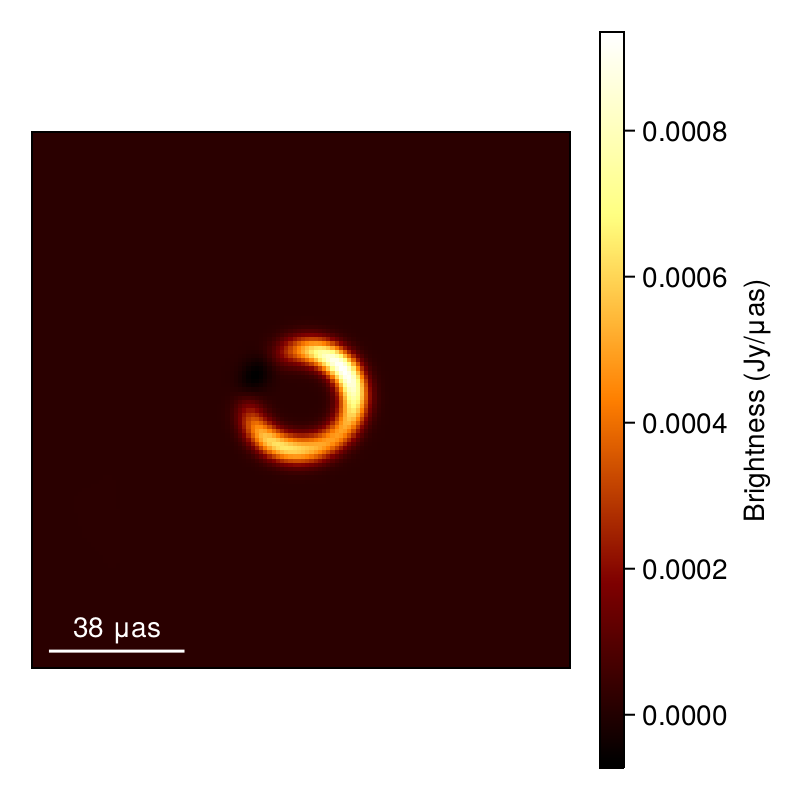

In [22]:
import CairoMakie as CM
g = imagepixels(μas2rad(150.0), μas2rad(150.0), 128, 128)
fig = imageviz(intensitymap(skymodel(post, xrand), g), size=(400, 400))

## 이미지 재구조화

In [23]:
tpost = asflat(post)

TransformedPosterior(
Posterior(
RadioLikelihood
	Number of data products: 1

Prior:
(c = GaussMarkovRandomField(
Graph: MarkovRandomFieldGraph{2}(
dims: (32, 32)
)
Correlation Parameter: 3.9947524783031394
), σimg = Truncated(Normal{Float64}(μ=0.0, σ=0.1); lower=0.01), f = Uniform{Float64}(a=0.0, b=1.0), ...)

)
Transform: Params to ℝ^1363
)

In [24]:
ndim = dimension(tpost)

1363

In [25]:
using ComradeOptimization
using OptimizationOptimJL
using Zygote
f = OptimizationFunction(tpost, Optimization.AutoZygote())
prob = Optimization.OptimizationProblem(f, prior_sample(rng, tpost), nothing)
sol = solve(prob, LBFGS(); maxiters=2000, g_tol=1e-0);

In [26]:
xopt = transform(tpost, sol)

(c = [-0.6005848407925495 -0.4721414473665031 … -1.0525128750357207 -0.8882883058861638; -0.7219487887256318 -0.5382399676288933 … -1.147106456775796 -0.9804796160256602; … ; -0.01269914603347907 -0.004222016207725452 … -0.45447842864149784 -0.3842555457489056; -0.2505135979680476 -0.21058030302804054 … -0.740368410972636 -0.612940963323865], σimg = 0.6024171400177886, f = 0.6977286916656573, r = 9.765606643414283e-11, σ = 1.4380213323176772e-11, τ = 0.09736499287391931, ξτ = -1.2390449415928027, ma = (0.27555078836890995, 0.07536840826825672), mp = (2.5870835858289363, 3.910351412263076), fg = 0.024937329699837807, lgamp = [0.007513827426962955, 0.010539623202060255, 0.01988101159805474, 0.026742047559959806, -0.23479089608363865, 0.08508802425585196, 0.007813098156124824, 0.03273477879858104, -0.023454367246568006, 0.051489259476540164  …  0.022598148579350878, 0.01740171707168057, -0.6248906054265834, 0.01650905472221437, 0.01450579539978749, 0.030654346583644854, -0.027589715573846

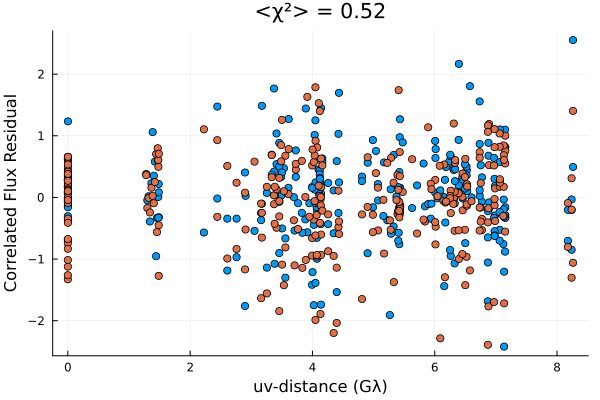

In [29]:
using Plots
fig = residual(vlbimodel(post, xopt), dvis, ylabel="Correlated Flux Residual")

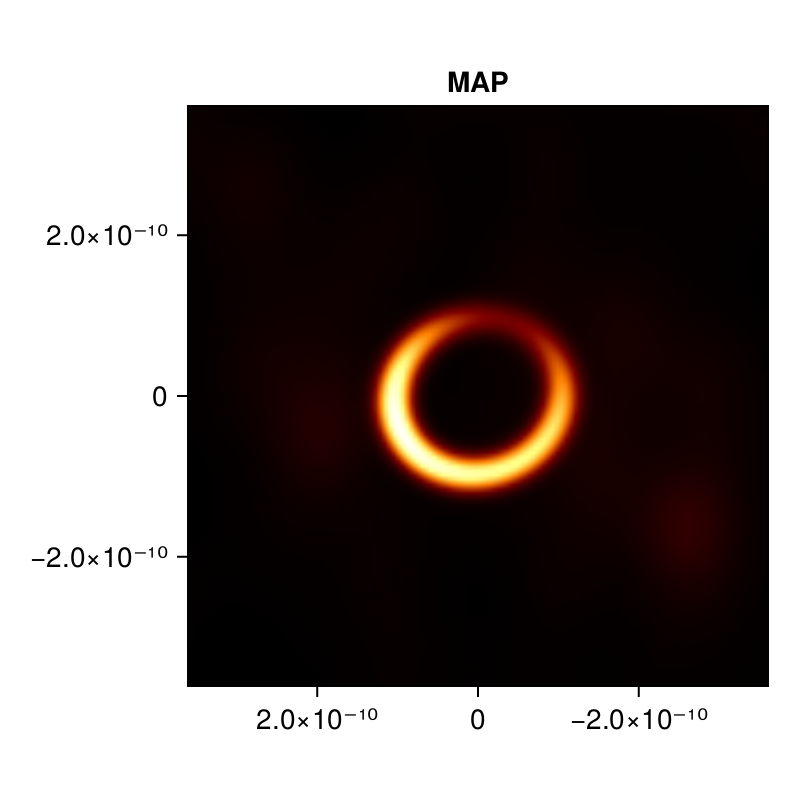

In [28]:
CM.image(g, 
    skymodel(post, xopt), 
    axis=(aspect=1, xreversed=true, title="MAP"), 
    colormap=:afmhot, 
    figure=(; size=(400, 400),))

In [30]:
using ComradeAHMC
metric = DiagEuclideanMetric(ndim)
chain, stats = sample(rng, post, AHMC(;metric, autodiff=Val(:Zygote)), 700; 
    n_adapts=500, initial_params=xopt, progress=false);

In [31]:
stats = stats[501:end]
chain = chain[501:end]

Table with 12 columns and 200 rows:
      c                     σimg      f         r            σ            ⋯
    ┌──────────────────────────────────────────────────────────────────────
 1  │ [-0.923754 0.594301…  0.456458  0.630021  1.06979e-10  2.03418e-11  ⋯
 2  │ [0.508453 -0.894304…  0.405735  0.657274  1.05116e-10  1.7632e-11   ⋯
 3  │ [-0.722071 -1.39534…  0.488638  0.674418  1.06518e-10  1.25997e-11  ⋯
 4  │ [-0.335158 -0.14592…  0.479761  0.704753  1.04861e-10  1.1796e-11   ⋯
 5  │ [-0.0866933 -0.7103…  0.466794  0.672991  1.03081e-10  1.43752e-11  ⋯
 6  │ [-0.399525 -0.56626…  0.486108  0.657421  1.07342e-10  1.37702e-11  ⋯
 7  │ [-0.740818 -0.18366…  0.495533  0.670608  1.06126e-10  1.47566e-11  ⋯
 8  │ [0.426948 -0.675625…  0.469283  0.721644  1.01335e-10  5.09916e-12  ⋯
 9  │ [-0.973964 -0.35252…  0.477873  0.721645  1.06249e-10  3.34296e-12  ⋯
 10 │ [-0.785533 -0.59804…  0.432509  0.739051  1.06387e-10  1.27942e-12  ⋯
 11 │ [-2.09992 -1.32514 …  0.4537    0.727941  1.04

In [32]:
using StatsBase
msamples = skymodel.(Ref(post), chain[begin:2:end]);

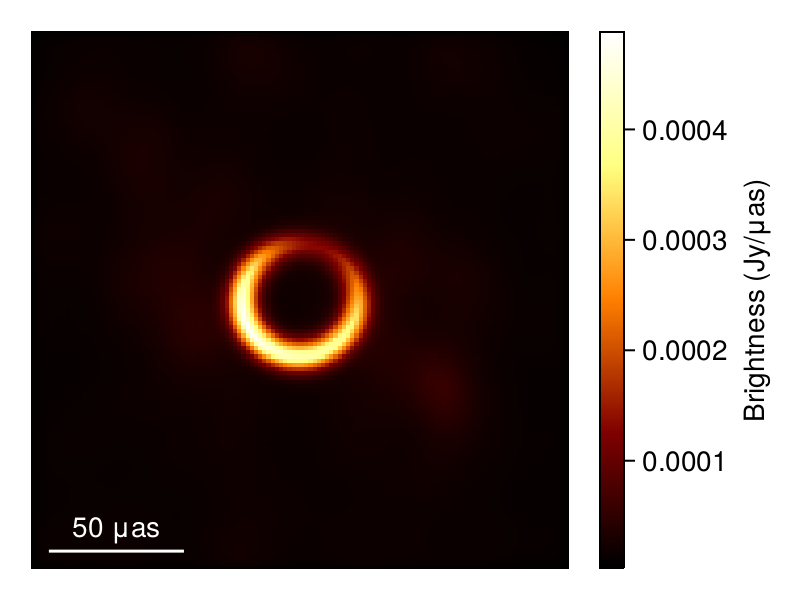

In [33]:
imgs = intensitymap.(msamples, fovxy, fovxy, 128, 128)
fig = imageviz(mean(imgs), colormap=:afmhot, size=(400, 300))

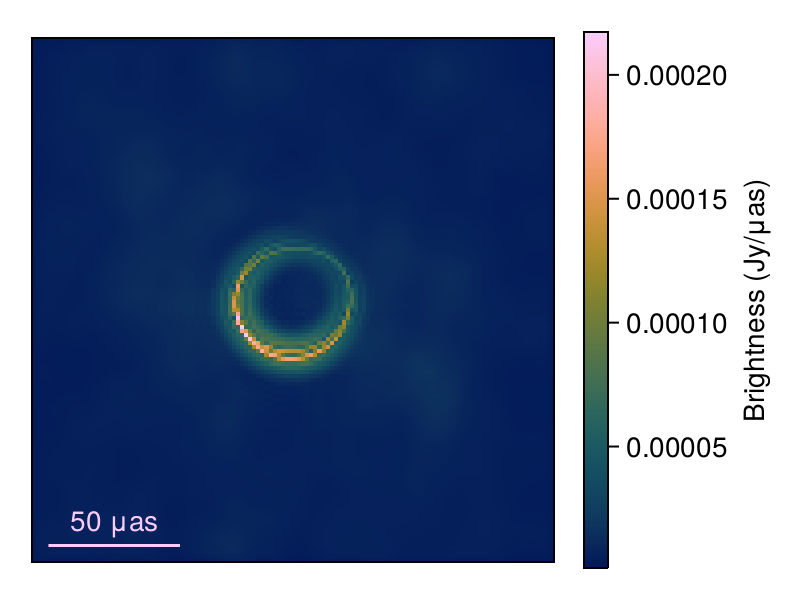

In [34]:
fig = imageviz(std(imgs), colormap=:batlow, size=(400, 300))

In [35]:
comp = Comrade.components.(msamples)
ring_samples = getindex.(comp, 2)
rast_samples = first.(comp)
ring_imgs = intensitymap.(ring_samples, fovxy, fovxy, 128, 128)
rast_imgs = intensitymap.(rast_samples, fovxy, fovxy, 128, 128)

ring_mean, ring_std = mean_and_std(ring_imgs);
rast_mean, rast_std = mean_and_std(rast_imgs);


# CM.hidedecorations!.(axes)

In [36]:
ring_mean

128×128 IntensityMap{Float64,2} with dimensions: 
  X Sampled{Float64} LinRange{Float64}(-4.81026e-10, 4.81026e-10, 128) ForwardOrdered Regular Points,
  Y Sampled{Float64} LinRange{Float64}(-4.81026e-10, 4.81026e-10, 128) ForwardOrdered Regular Points
               -4.81026e-10  -4.73451e-10  …  4.73451e-10  4.81026e-10
 -4.81026e-10   0.0           0.0             0.0          0.0
 -4.73451e-10   0.0           0.0             0.0          0.0
 -4.65876e-10   0.0           0.0             0.0          0.0
 -4.583e-10     0.0           0.0             0.0          0.0
 -4.50725e-10   0.0           0.0          …  0.0          0.0
 -4.4315e-10    0.0           0.0             0.0          0.0
 -4.35575e-10   0.0           0.0             0.0          0.0
 -4.28e-10      0.0           0.0             0.0          0.0
  ⋮                                        ⋱  ⋮            
  4.20424e-10   0.0           0.0          …  0.0          0.0
  4.28e-10      0.0           0.0             0.0

In [37]:
ring_std

128×128 IntensityMap{Float64,2} with dimensions: 
  X Sampled{Float64} LinRange{Float64}(-4.81026e-10, 4.81026e-10, 128) ForwardOrdered Regular Points,
  Y Sampled{Float64} LinRange{Float64}(-4.81026e-10, 4.81026e-10, 128) ForwardOrdered Regular Points
               -4.81026e-10  -4.73451e-10  …  4.73451e-10  4.81026e-10
 -4.81026e-10   0.0           0.0             0.0          0.0
 -4.73451e-10   0.0           0.0             0.0          0.0
 -4.65876e-10   0.0           0.0             0.0          0.0
 -4.583e-10     0.0           0.0             0.0          0.0
 -4.50725e-10   0.0           0.0          …  0.0          0.0
 -4.4315e-10    0.0           0.0             0.0          0.0
 -4.35575e-10   0.0           0.0             0.0          0.0
 -4.28e-10      0.0           0.0             0.0          0.0
  ⋮                                        ⋱  ⋮            
  4.20424e-10   0.0           0.0          …  0.0          0.0
  4.28e-10      0.0           0.0             0.0

In [38]:
rast_mean

128×128 IntensityMap{Float64,2} with dimensions: 
  X Sampled{Float64} LinRange{Float64}(-4.81026e-10, 4.81026e-10, 128) ForwardOrdered Regular Points,
  Y Sampled{Float64} LinRange{Float64}(-4.81026e-10, 4.81026e-10, 128) ForwardOrdered Regular Points
               -4.81026e-10  -4.73451e-10  …  4.73451e-10  4.81026e-10
 -4.81026e-10   8.25547e-6    1.0723e-5       8.77829e-6   6.83372e-6
 -4.73451e-10   1.06093e-5    1.37853e-5      1.1308e-5    8.80085e-6
 -4.65876e-10   1.23047e-5    1.59972e-5      1.31641e-5   1.02414e-5
 -4.583e-10     1.32397e-5    1.72246e-5      1.42475e-5   1.10784e-5
 -4.50725e-10   1.3637e-5     1.77527e-5   …  1.48063e-5   1.15056e-5
 -4.4315e-10    1.37335e-5    1.78848e-5      1.51034e-5   1.17288e-5
 -4.35575e-10   1.37611e-5    1.79181e-5      1.53963e-5   1.1949e-5
 -4.28e-10      1.38419e-5    1.80103e-5      1.58132e-5   1.22661e-5
  ⋮                                        ⋱  ⋮            
  4.20424e-10   1.96153e-5    2.53065e-5   …  2.24937e-5 

In [39]:
rast_std

128×128 IntensityMap{Float64,2} with dimensions: 
  X Sampled{Float64} LinRange{Float64}(-4.81026e-10, 4.81026e-10, 128) ForwardOrdered Regular Points,
  Y Sampled{Float64} LinRange{Float64}(-4.81026e-10, 4.81026e-10, 128) ForwardOrdered Regular Points
               -4.81026e-10  -4.73451e-10  …  4.73451e-10  4.81026e-10
 -4.81026e-10   3.51019e-6    4.50424e-6      3.01581e-6   2.39886e-6
 -4.73451e-10   4.34637e-6    5.58841e-6      3.83024e-6   3.04129e-6
 -4.65876e-10   4.79676e-6    6.18488e-6      4.40926e-6   3.49191e-6
 -4.583e-10     4.91874e-6    6.35781e-6      4.78815e-6   3.78044e-6
 -4.50725e-10   4.92688e-6    6.36913e-6   …  5.09084e-6   4.00856e-6
 -4.4315e-10    4.93509e-6    6.3612e-6       5.37315e-6   4.22228e-6
 -4.35575e-10   4.94867e-6    6.34792e-6      5.64721e-6   4.43213e-6
 -4.28e-10      4.99484e-6    6.37087e-6      5.954e-6     4.6743e-6
  ⋮                                        ⋱  ⋮            
  4.20424e-10   7.75956e-6    9.76779e-6   …  8.70112e-6 

In [40]:
fig = CM.Figure(; resolution=(400, 400));
axes = [CM.Axis(fig[i, j], xreversed=true, aspect=CM.DataAspect()) for i in 1:2, j in 1:2]
CM.image!(axes[1,1], ring_mean, colormap=:afmhot); axes[1,1].title = "Ring Mean"
CM.image!(axes[1,2], ring_std, colormap=:afmhot); axes[1,2].title = "Ring Std. Dev."
CM.image!(axes[2,1], rast_mean, colormap=:afmhot); axes[2,1].title = "Rast Mean"
CM.image!(axes[2,2], rast_std, colormap=:afmhot); axes[2,2].title = "Rast Std. Dev."
CM.hidedecorations!.(axes)b

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/bread/.julia/packages/Makie/z2T2o/src/scenes.jl:220


LoadError: UndefVarError: b not defined

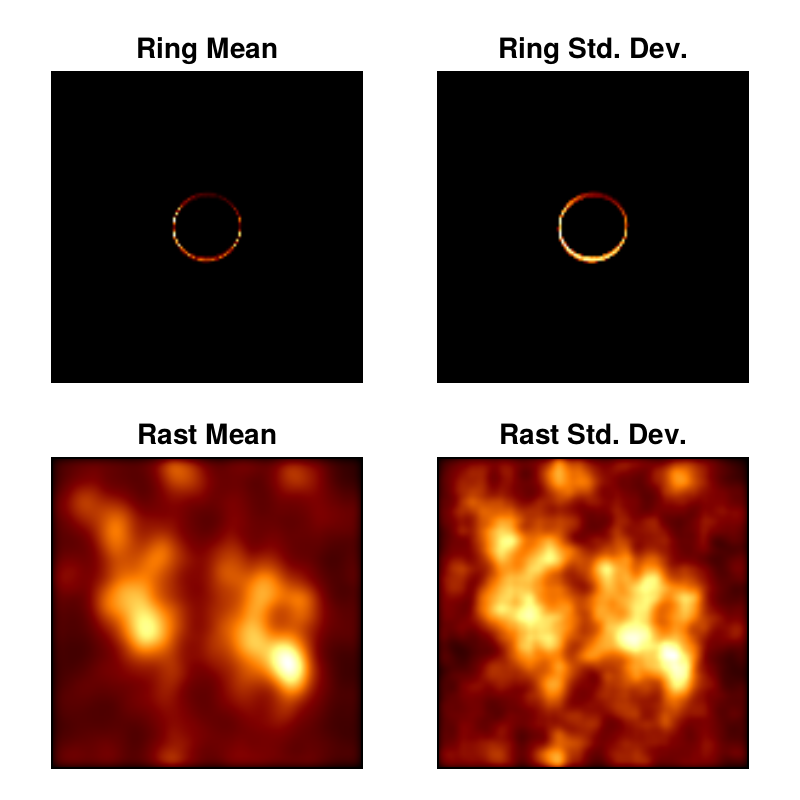

CairoMakie.Screen{IMAGE}


In [41]:
display(fig)

In [42]:
figd = CM.Figure(;size=(600, 400));
p1 = CM.density(figd[1,1], rad2μas(chain.r)*2, axis=(xlabel="Ring Diameter (μas)",))
p2 = CM.density(figd[1,2], rad2μas(chain.σ)*2*sqrt(2*log(2)), axis=(xlabel="Ring FWHM (μas)",))
p3 = CM.density(figd[1,3], -rad2deg.(getindex.(chain.mp, 1)) .+ 360.0, axis=(xlabel = "Ring PA (deg) E of N",))
p4 = CM.density(figd[2,1], 2*getindex.(chain.ma, 2), axis=(xlabel="Brightness asymmetry",))
p5 = CM.density(figd[2,2], 1 .- chain.f, axis=(xlabel="Ring flux fraction",))

Makie.AxisPlot(Axis (1 plots), MakieCore.Plot{Makie.density, Tuple{Vector{Float64}}})

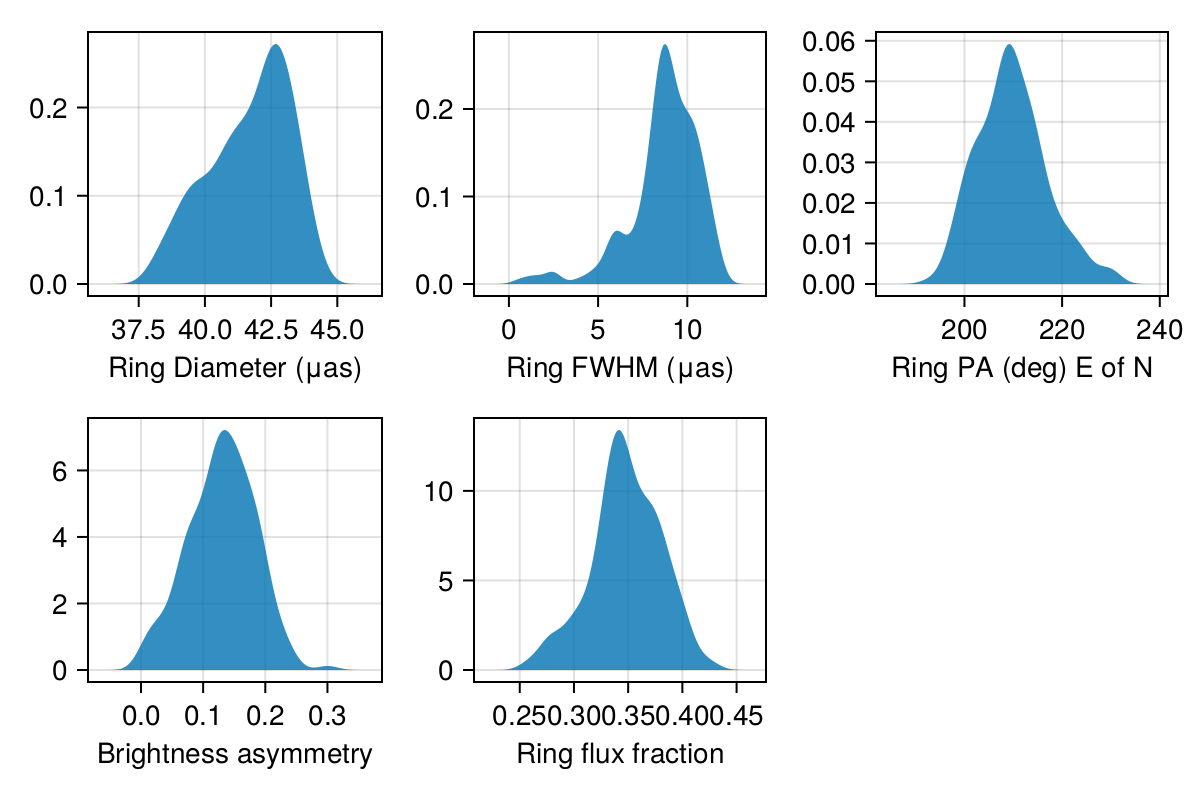

CairoMakie.Screen{IMAGE}


In [43]:
display(figd)

In [44]:
p = Plots.plot();
for s in sample(chain, 10)
    residual!(p, vlbimodel(post, s), dvis)
end

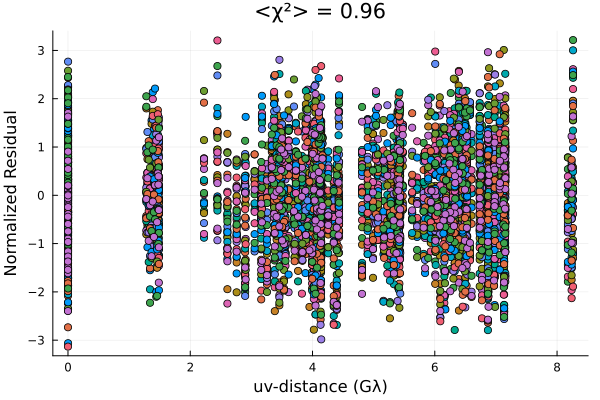

In [45]:
display(p)